# A Cointegration-Based Pairs Trading Strategy for Cryptocurrencies
- by Scormon Ho Rui Sheng
- on Aug 2025

---
## Introduction
This project explores a pairs trading strategy in the context of cryptocurrency markets, rather than traditional equities. This analysis uses cryptocurrency price data obtained from [CoinGecko](https://www.coingecko.com/). The strategy is built around finding cryptocurrency pairs that exhibit **cointegration**, using statistical tests applied over a training period. Pairs demonstrating the strongest cointegration relationships during this training period are selected for trading.

In pairs trading, trading signals determine when to open or close positions. When a signal is triggered, the strategy simultaneously takes **long and short positions** in the two assets (buying one cryptocurrency while selling the other). The exposure to each asset is adjusted according to the hedge rato, ensuring a balanced position. Positions are then closed once exit conditions are met.

Profit and loss (P&L) are calculated based on the execution prices at entry and exit points. For simplicity, this analysis **assumes zero transaction costs**, through in practice such costs can significantly influence profitability.

---
## Install dependencies

In [1]:
# !pip install statsmodels

---
## Loading the libraries

In [2]:
# IMPORTS
import pandas as pd
import numpy as np

from tqdm import notebook
from pathlib import Path
from datetime import timedelta, datetime

# Import the plotting library
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator

import seaborn as sns
sns.set()

plt.rcParams.update({'figure.figsize':(15,7), 'figure.dpi':120})

---
## Loading the prices downloaded from CoinGecko
The dataset folder used in this analysis is available for download [here](https://drive.google.com/drive/folders/1xnRCzH8ocIb8mu-9Wd99AK1kjH7bsSwQ?usp=sharing).

In [3]:
path = "tickers/" # path to dataset folder

def load_prices(path):
    frames = []
    for f in Path(path).glob("*.csv"):
        s = (pd.read_csv(f, usecols=["snapped_at", "price"])
               .assign(snapped_at=lambda x: pd.to_datetime(x["snapped_at"], utc=True))
               .set_index("snapped_at")["price"]
               .rename(f.stem.replace("-usd-max", "")))
        frames.append(s)
    return pd.concat(frames, axis=1).sort_index()

prices = load_prices(path) # dataframe of prices for all CSVs in folder
prices = prices[sorted(prices.columns)]
print(prices.shape)
print(prices.tail())

(4508, 13)
                                ada         bch         bnb            btc  \
snapped_at                                                                   
2025-08-15 00:00:00+00:00  0.925791  594.312825  842.264319  118405.595798   
2025-08-16 00:00:00+00:00  0.941799  592.456208  827.291681  117339.791902   
2025-08-17 00:00:00+00:00  0.920232  587.786836  839.056661            NaN   
2025-08-18 00:00:00+00:00  0.963210  583.281226  856.942456            NaN   
2025-08-19 00:00:00+00:00  0.923455  569.443998  848.229879            NaN   

                               doge          eth       link         sol  \
snapped_at                                                                
2025-08-15 00:00:00+00:00  0.224190  4554.291502  22.499603  192.756804   
2025-08-16 00:00:00+00:00  0.228213  4430.532465  21.746992  185.599695   
2025-08-17 00:00:00+00:00  0.231019  4426.826913  22.659442  189.769423   
2025-08-18 00:00:00+00:00  0.235436          NaN  25.679903  191.64

Remove rows that contain any NaN

In [4]:
prices.dropna(inplace=True)

Check to ensure that there are no NaN prices for analysis

In [5]:
prices.isnull().any().any()

False

In [6]:
prices.head()

,ada,bch,bnb,btc,doge,eth,link,sol,sui,trx,usde,win,xlm
snapped_at,,,,,,,,,,,,,
2023-12-14 00:00:00+00:00,0.661389,235.386731,252.218064,42931.761826,0.096412,2260.882353,14.770819,70.738397,0.653847,0.104315,0.997449,0.000092,0.124791
2023-12-15 00:00:00+00:00,0.642451,237.084139,253.565564,43009.595456,0.098319,2317.465074,15.401402,75.655888,0.654980,0.106051,0.997449,0.000094,0.127438
2023-12-16 00:00:00+00:00,0.602040,226.716007,244.668516,41992.014187,0.092961,2219.951618,14.269411,72.618144,0.617722,0.101430,0.998449,0.000090,0.122656
2023-12-19 00:00:00+00:00,0.600871,228.001911,241.100016,42684.182555,0.091995,2216.929014,14.648517,74.340927,0.608954,0.100960,1.001612,0.000087,0.120966
2023-12-20 00:00:00+00:00,0.575001,224.890912,252.047477,42250.206183,0.090109,2176.839413,14.071076,72.611450,0.678639,0.100547,1.001612,0.000087,0.119168


In [7]:
prices.tail()

,ada,bch,bnb,btc,doge,eth,link,sol,sui,trx,usde,win,xlm
snapped_at,,,,,,,,,,,,,
2025-08-12 00:00:00+00:00,0.774244,579.247642,806.831219,118773.799609,0.222797,4228.824213,21.168388,175.045126,3.660939,0.345488,1.000873,0.000060,0.431221
2025-08-13 00:00:00+00:00,0.842123,618.747451,834.446638,120202.534855,0.236286,4606.809428,23.476864,192.594128,3.886980,0.352380,1.000499,0.000063,0.448816
2025-08-14 00:00:00+00:00,0.908326,616.986897,849.552866,123560.993636,0.245499,4763.652535,24.068226,201.818688,4.019285,0.362244,1.000678,0.000064,0.453110
2025-08-15 00:00:00+00:00,0.925791,594.312825,842.264319,118405.595798,0.224190,4554.291502,22.499603,192.756804,3.763441,0.358478,1.001428,0.000061,0.424020
2025-08-16 00:00:00+00:00,0.941799,592.456208,827.291681,117339.791902,0.228213,4430.532465,21.746992,185.599695,3.706681,0.352168,1.001740,0.000061,0.429697


Splitting the prices to training and testing.  Training dataset to analyse and identify cointegrated pairs and parameters to be used in testing dataset which is unseen (out-of-sample).

Here, Feb 2024 to Feb 2025 prices are used for analysis and to test the trading strategy on Mar to Jul 2025.

In [8]:
train_prices = prices['2024-02':'2025-02']
test_prices = prices['2025-03':'2025-07']

In [9]:
train_prices.head()

,ada,bch,bnb,btc,doge,eth,link,sol,sui,trx,usde,win,xlm
snapped_at,,,,,,,,,,,,,
2024-02-01 00:00:00+00:00,0.497789,234.215665,300.213320,42583.263547,0.078694,2282.485867,15.409997,96.931800,1.520639,0.112196,0.992525,0.000092,0.109951
2024-02-02 00:00:00+00:00,0.505482,236.545154,299.911405,43069.043421,0.079280,2301.737299,17.124666,97.790031,1.528694,0.115418,0.997853,0.000094,0.109821
2024-02-03 00:00:00+00:00,0.514163,236.221718,301.174354,43170.658562,0.079271,2307.432998,17.767217,100.465481,1.463400,0.116251,0.999233,0.000094,0.110375
2024-02-04 00:00:00+00:00,0.512337,238.303038,299.718153,42976.848300,0.078708,2294.715925,17.640431,97.767138,1.433193,0.117204,0.999328,0.000093,0.110942
2024-02-05 00:00:00+00:00,0.494902,235.290471,304.764843,42599.359971,0.078244,2290.084493,18.192018,95.472110,1.467770,0.118329,0.997920,0.000094,0.109359


In [10]:
test_prices.head()

,ada,bch,bnb,btc,doge,eth,link,sol,sui,trx,usde,win,xlm
snapped_at,,,,,,,,,,,,,
2025-03-01 00:00:00+00:00,0.634072,316.135644,587.546927,84441.901224,0.202091,2235.204209,14.834418,148.174663,2.831568,0.233242,0.998614,0.000066,0.286430
2025-03-02 00:00:00+00:00,0.658260,311.273110,608.288567,86005.256297,0.206364,2212.824351,14.798925,143.400223,2.818507,0.233951,0.998806,0.000064,0.311674
2025-03-03 00:00:00+00:00,1.138340,334.040749,623.642227,94261.532865,0.239848,2517.338239,17.354656,178.174132,3.201276,0.243757,0.999104,0.000067,0.350671
2025-03-04 00:00:00+00:00,0.856808,320.648506,574.333282,86124.714187,0.199208,2148.199533,14.463317,142.514127,2.619939,0.230599,0.998751,0.000060,0.292193
2025-03-05 00:00:00+00:00,0.943545,320.181096,583.153209,87310.805311,0.199210,2171.496944,14.870707,145.061909,2.534663,0.242199,0.998825,0.000063,0.295206


---
## Finding Cointegration

Functions used:
- `find_cointegrated_pairs` - for matrix heatmap
- `find_cointegrated_pairs_v2` - returns lists of all cointegration test scores, p-values and pairs 
- `search_coint_pairs` - returns table of ranked cointegration pairs 

In [11]:
from statsmodels.tsa.stattools import coint

In [12]:
def find_cointegrated_pairs(data, conf=0.05): 
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < conf:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [13]:
def find_cointegrated_pairs_v2(data):
    n = data.shape[1]
    keys = data.keys()

    pairs = []
    scores = []
    pvalues = []
    for i in range(n):
        for j in range(i+1, n):
            try:
                S1 = data[keys[i]]
                S2 = data[keys[j]]
                result = coint(S1, S2)
                scores.append(result[0])
                pvalues.append(result[1])
                pairs.append((keys[i], keys[j]))
            except ValueError as error:
                print(error)
                pass
                      
    return scores, pvalues, pairs

In [14]:
def search_coint_pairs(prices_df, conf=0.05):
    
    scores, pvalues, pairs = find_cointegrated_pairs_v2(prices_df)
    coint_pairs = pd.DataFrame(list(zip(scores, pvalues, pairs)), 
                               columns=['scores','pvalues','pairs'])

    return coint_pairs.sort_values('pvalues')

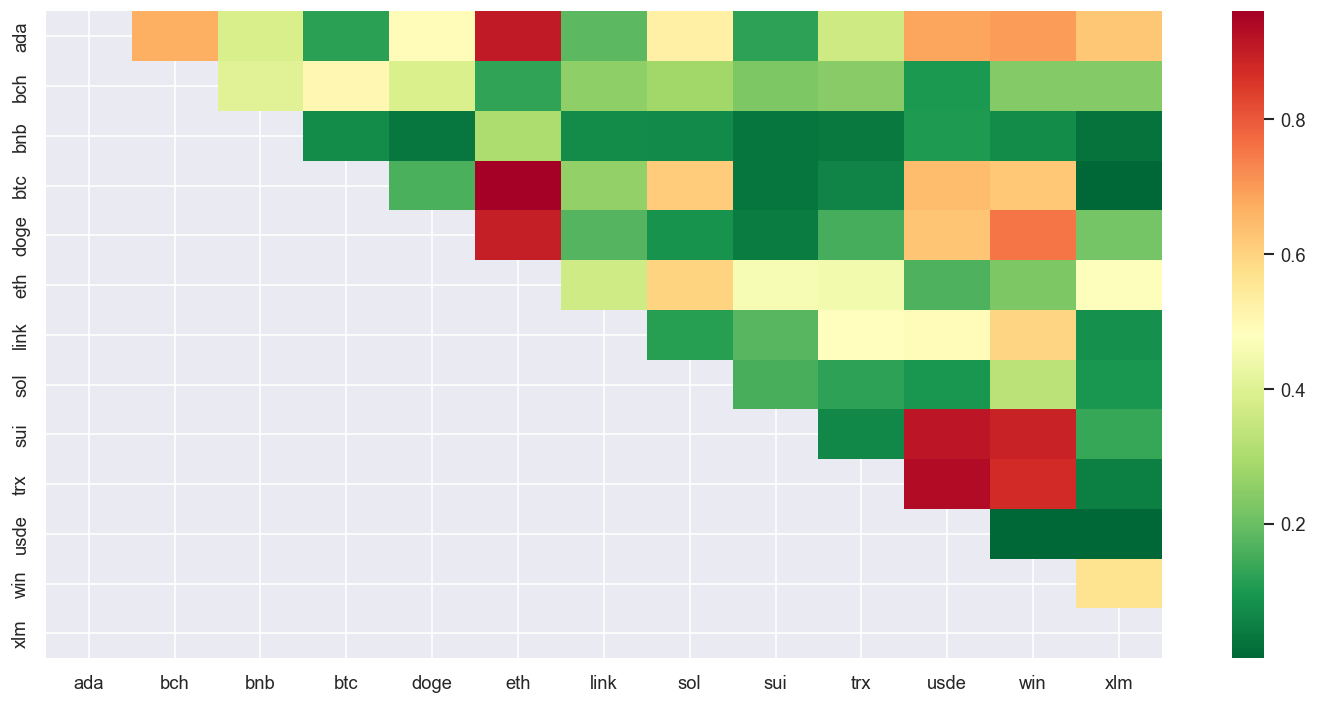

In [15]:
# Heatmap to show the p-values of the cointegration test between each pair of stocks
scores, pvalues, pairs = find_cointegrated_pairs(train_prices)

plt.figure(figsize=(15,7))

sns.heatmap(pvalues, xticklabels=prices.columns, yticklabels=prices.columns, cmap='RdYlGn_r', mask = (pvalues >= 1))

plt.show()

Cointergrated pairs have p-values close to zero. The above heatmap shows the list of cointegrated pairs that potentially could be considered for this pair trading strategy.

Select the best pair for analysis.

In [16]:
top_pairs = search_coint_pairs(train_prices, 0.05).head()
print(top_pairs)

      scores   pvalues        pairs
41 -4.665632  0.000646   (btc, xlm)
75 -4.437962  0.001546  (usde, win)
76 -4.351917  0.002122  (usde, xlm)
32 -3.585413  0.025538   (bnb, xlm)
28 -3.558048  0.027585   (bnb, sui)


In [17]:
num = 0 # using the pair with the smallest p-value

P1 = top_pairs.iloc[num].pairs[0]
P2 = top_pairs.iloc[num].pairs[1]
print('Coin 1: {} vs Coin 2: {}'.format(P1, P2))

Coin 1: btc vs Coin 2: xlm


In [18]:
S1 = train_prices[P1]
S2 = train_prices[P2]

In [19]:
print('Last price of {}: {} vs Last price of {}: {}'.format(P1, S1.iloc[-1], P2, S2.iloc[-1]))

Last price of btc: 84709.14477847965 vs Last price of xlm: 0.2830862189715135


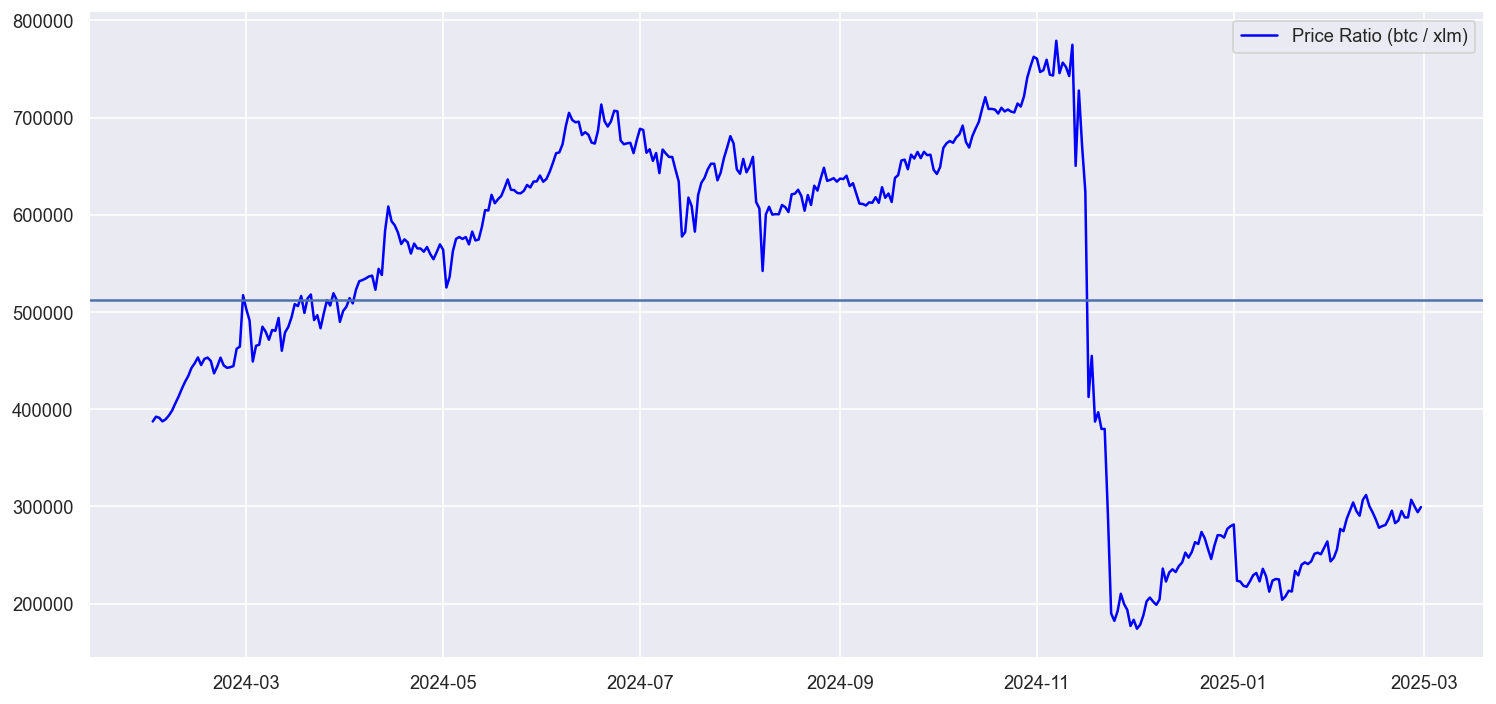

Mean ratio: 512131.21


In [20]:
score, pvalue, _ = coint(S1, S2)
ratios = S1 / S2

plt.figure(figsize=(15,7))

plt.plot(ratios.index, ratios, color='blue')
plt.axhline(ratios.mean())
plt.legend([f'Price Ratio ({P1} / {P2})'])
plt.show()

print('Mean ratio: {:.2f}'.format(ratios.mean()))

We should expect the ratio to move around a stable mean.  Normalising the ratio below.

In [21]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

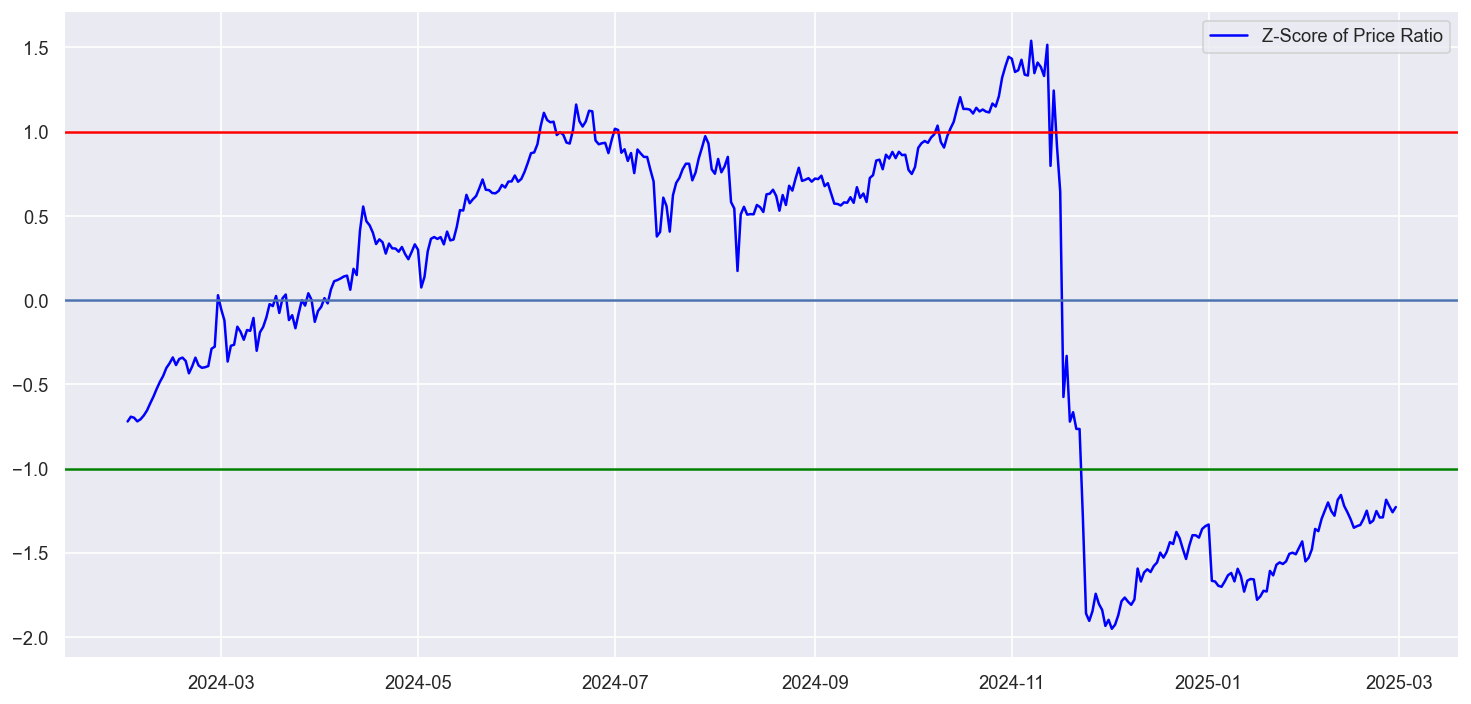

In [22]:
plt.figure(figsize=(15,7))

plt.plot(zscore(ratios).index, zscore(ratios), color='blue')
plt.axhline(zscore(ratios).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.legend([f'Z-Score of Price Ratio'])
plt.show()

We should expect the ratio's z-score to oscillate between the mean of zero.  When there is huge divergence, there will be trading opportunities.

---
## Feature Engineering

We want to predict the direction of the ratio move.  As the pair are cointegrated, we expect the ratio to revert back to its mean.  Instead of using the mean and standard deviation of the prices over the full training period, we will use rolling moving averages instead.  This way, the most recent data are used to engineer the trading signal.

Using the following features for analysis purposes:
1. Mean (60MA) - 60 days of moving average of ratio
2. Standard Deviation (60SD) - 60 days standard deviation of ratio
3. Latest Ratio (5MA) - 5 days of moving average of ratio
4. Z-Score (Z) - (5MA - 60MA) / 60SD

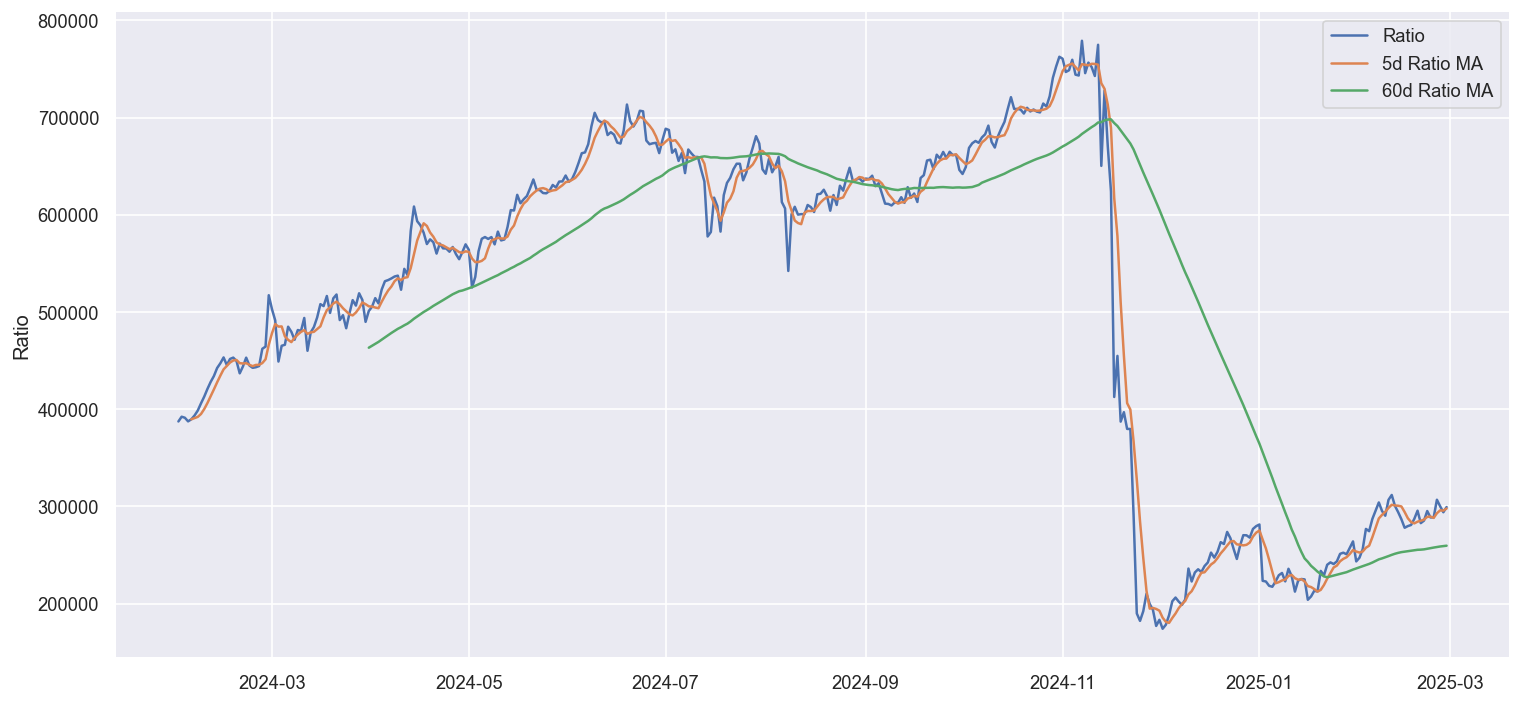

In [23]:
ratios_mavg5 = ratios.rolling(window=5, center=False).mean()
ratios_mavg60 = ratios.rolling(window=60, center=False).mean()
std_60 = ratios.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

plt.figure(figsize=(15,7))
plt.plot(ratios.index, ratios.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

Visually, we are expecting the orange line to close up (mean-revert) to the green line in the shortest possible time.  While divergence generates trading opportunities, prolonged divergence is not good for the strategy.  Prolonged divergence will lead to:
1. Closing of position at extreme deviated prices leading to potential losses
2. Long holding periods

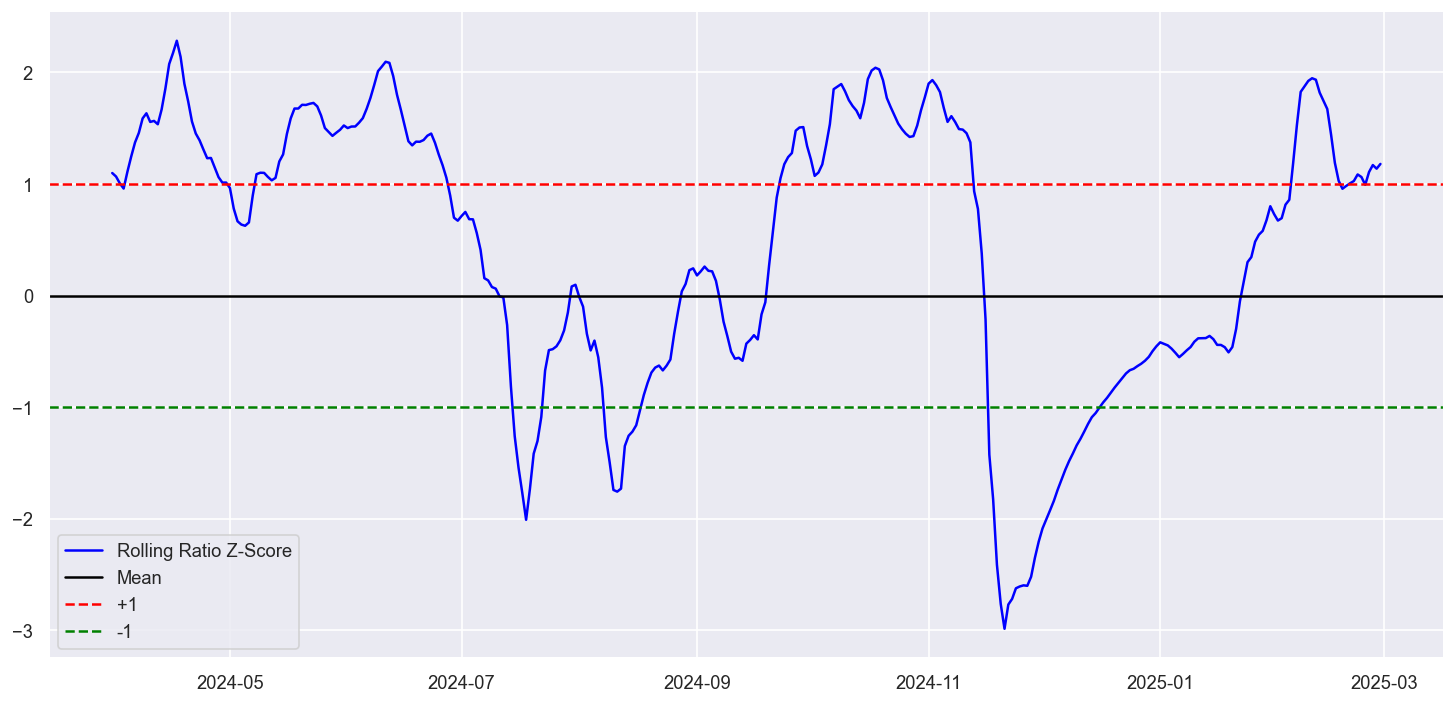

In [24]:
plt.figure(figsize=(15,7))

plt.plot(zscore_60_5.index, zscore_60_5, color='blue')

plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio Z-Score', 'Mean', '+1', '-1'])
plt.show()

The z-score should mean revert to 0.  Possible trading signal when there is extreme deviation from mean 0.  
- When z-score is above the red line, Short: Short Coin 1 and Long Coin 2
- When z-score is below the green line, Short: Long Coin 1 and Short Coin 2

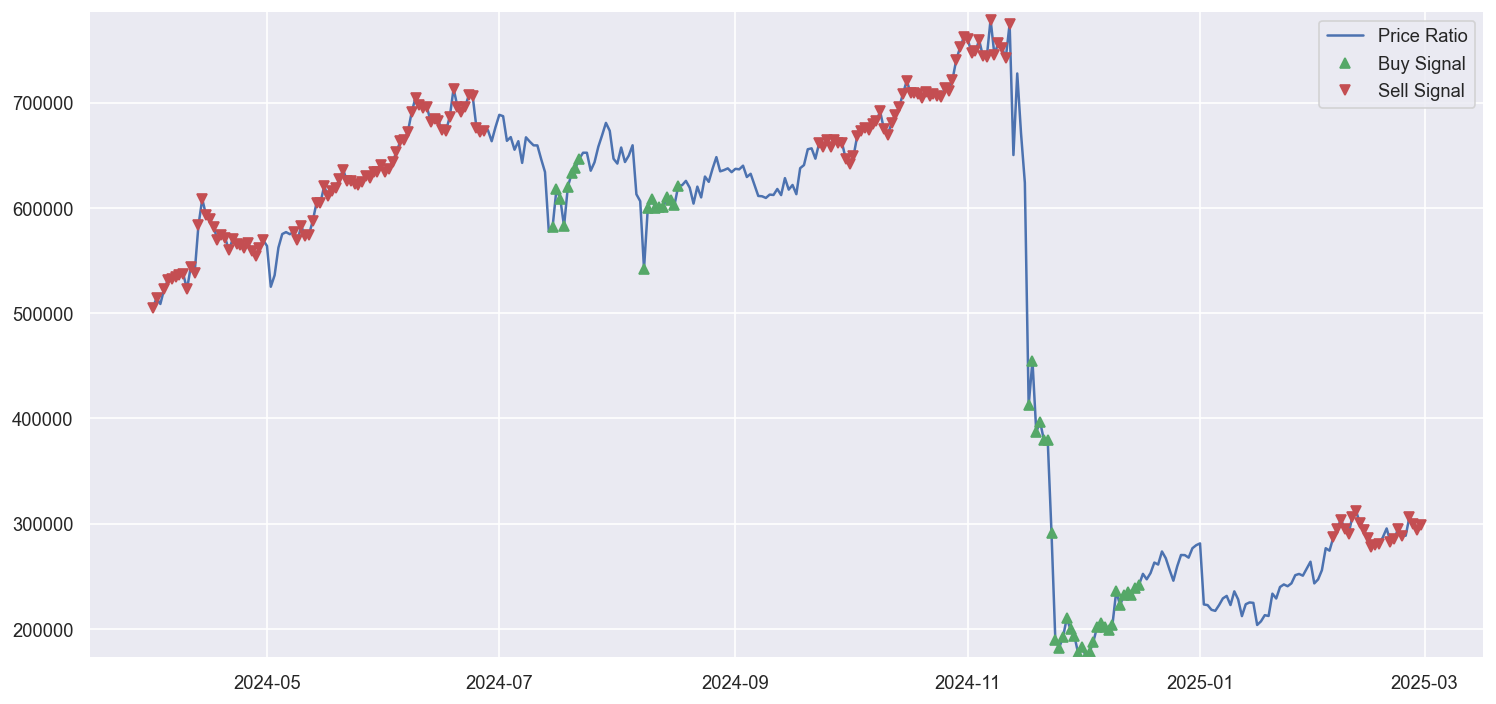

In [25]:
# Plot the ratios and buy and sell signals from z-score
plt.figure(figsize=(15,7))

plt.plot(ratios[60:].index, ratios[60:])

buy = ratios.copy()
sell = ratios.copy()
buy[zscore_60_5 > -1] = 0
sell[zscore_60_5 < 1] = 0

plt.plot(buy[60:].index, buy[60:], color='g', linestyle='None', marker='^')
plt.plot(sell[60:].index, sell[60:], color='r', linestyle='None', marker='v')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios[60:].min()*0.99,ratios[60:].max()*1.01))
plt.legend(['Price Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

The trading signals to buy and sell.  Green dots are buying signals.  Red dots are selling signals.

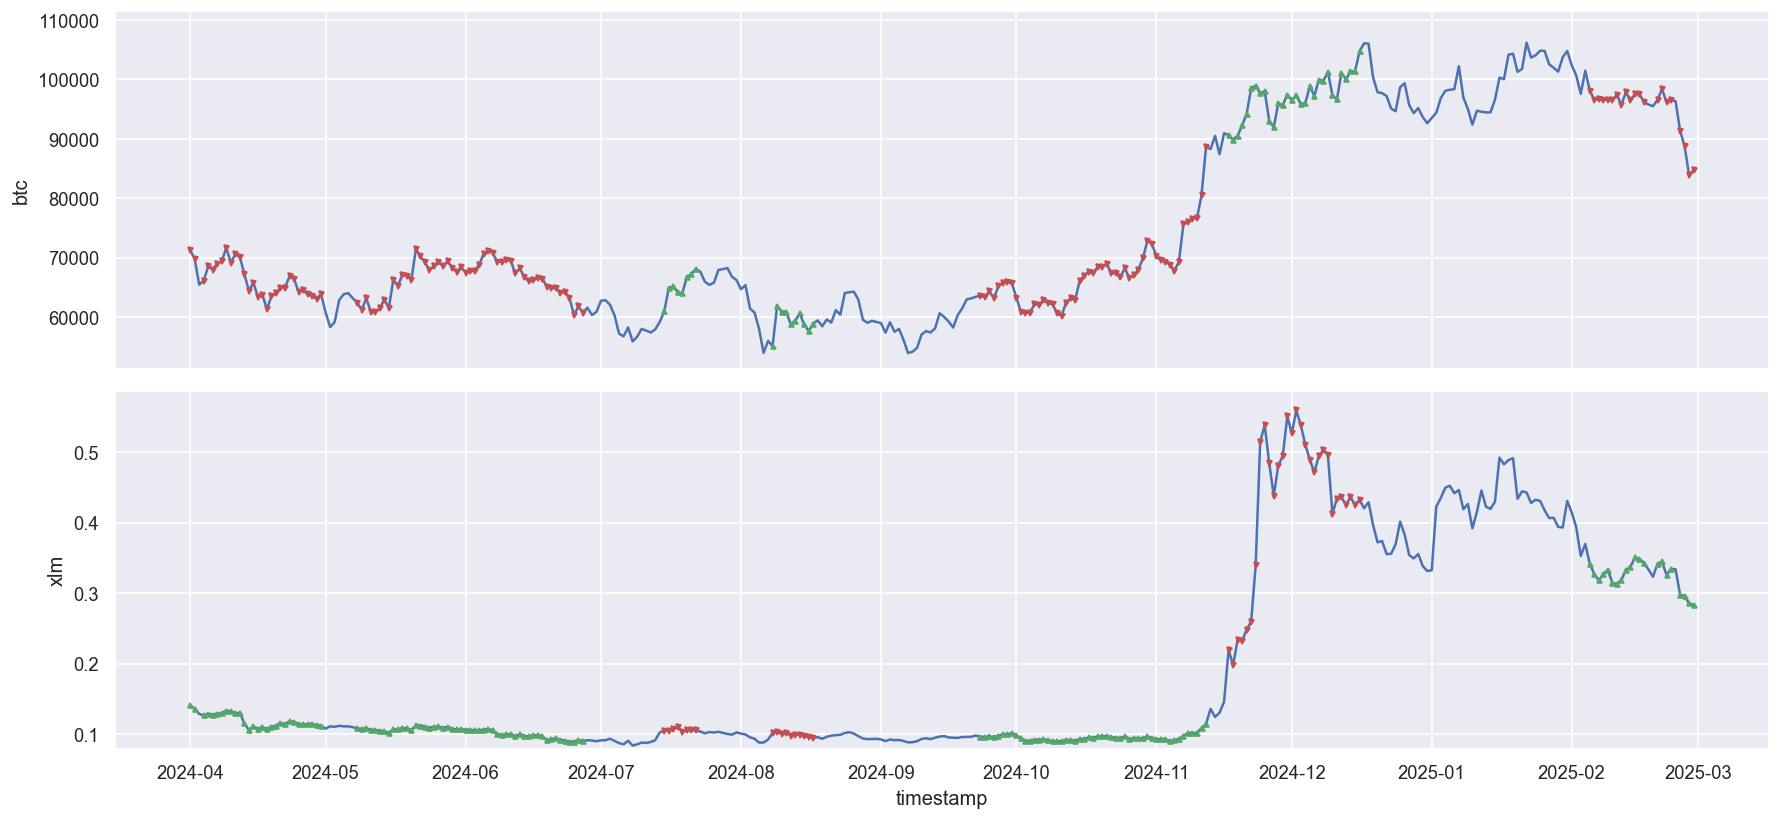

In [26]:
# Plot the prices and buy and sell signals from z-score

buyS1 = 0*S1.copy()
sellS1 = 0*S1.copy()
buyS2 = 0*S2.copy()
sellS2 = 0*S2.copy()

# # When buying the ratio, buy S1 and sell S2
buyS1[buy!=0] = S1[buy!=0]
sellS2[buy!=0] = S2[buy!=0]

# # When selling the ratio, sell S1 and buy S2 
buyS2[sell!=0] = S2[sell!=0]
sellS1[sell!=0] = S1[sell!=0]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.set_ylabel(P1)
ax1.plot(S1[60:].index, S1[60:], color='b')
ax1.tick_params(axis='y')
ax1.plot(S1[60:].index, buyS1[60:], color='g', linestyle='None', marker='^', markersize=3)
ax1.plot(S1[60:].index, sellS1[60:], color='r', linestyle='None', marker='v', markersize=3)
ax1.set_ylim([min(S1[60:])*0.95, max(S1[60:])*1.05])

ax2.set_ylabel(P2)  # we already handled the x-label with ax1
ax2.plot(S2[60:].index, S2[60:], color='b')
ax2.tick_params(axis='y')
ax2.plot(S2[60:].index, buyS2[60:], color='g', linestyle='None', marker='^', markersize=3)
ax2.plot(S2[60:].index, sellS2[60:], color='r', linestyle='None', marker='v', markersize=3)
ax2.set_ylim([min(S2[60:])*0.95, max(S2[60:])*1.05])

ax2.set_xlabel('timestamp')

# Define the date format
date_form = DateFormatter("%Y-%m")
ax2.xaxis.set_major_formatter(date_form)
locator = MonthLocator()
ax2.xaxis.set_major_locator(locator)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Similarly, the above plots show that buying and selling signals of each pairs.  It is best to observe both prices move in tandem with minimal deviation.

---
## Trading Strategy

Execute trades when the signal meets the following triggering criterias at any particular time.

##### Signal
- **Z-Score** = $\Large\frac{(Near_{MA} - Far_{MA})}{Std(Far_{MA})}$

##### Trigger
- **Buy**: When there is no existing position and z-score < -1  
- **Sell**: When there is no existing position and z-score > 1
- **Close all**: When there is existing position and -1 <= z-score <= 1

##### Trade
*Where n = Price of Coin 1 / Price of Coin 2*
- **Buy Signal**: Buy 1 x Coin 1 and Sell n x Coin 2
- **Sell Signal**: Sell 1 x Coin 1 and Buy n x Coin 2 


The trade function executes the strategy by taking in the following parameters:
1. **P1** - Coin 1 symbol
2. **P2** - Coin 2 symbol
3. **near** - short term moving average period (used as an estimate of current price)
4. **far** - long term moving average period (used as an estimate of mean price in which current price will revert to)
5. **test** - Default is False. Set to True to use the test dataset (instead of training).

In [27]:
# Trade using a simple strategy
def trade(P1, P2, near, far, test=False):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (near == 0) or (far == 0) or (near >= far):
        return 0
    
    # Select prices to use: train or test data
    if test:
        price1 = test_prices[P1]
        price2 = test_prices[P2]    
    else:
        price1 = train_prices[P1]
        price2 = train_prices[P2]
    
    # Compute rolling mean and rolling standard deviation
    # Trading signals for execution
    ratios = price1/price2
    ma1 = ratios.rolling(window=near, center=False).mean()
    ma2 = ratios.rolling(window=far, center=False).mean()
    std = ratios.rolling(window=far, center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    drawdown = 0
    
    # Logging all transactions for validation
    transactions = []
    
    def logTxn(datetime, action1, coin1, price1, qty1, action2, coin2, price2, qty2, zscore, hedgeratio, pnl, drawdown=0, holdingperiod=timedelta(0)):
        
        txn = {}
        txn['datetime'] = datetime
        txn['action1'] = action1
        txn['coin1'] = coin1
        txn['price1'] = price1
        txn['qty1'] = qty1
        txn['action2'] = action2
        txn['coin2'] = coin2
        txn['price2'] = price2
        txn['qty2'] = qty2
        txn['zscore'] = zscore
        txn['hedgeratio'] = hedgeratio
        txn['net_pnl'] = pnl
        txn['drawdown'] = drawdown
        txn['holdingperiod'] = holdingperiod
        
        return txn
    
    # Simulate trading period by period
    # Trade on trading signals derived based on information only available at the point in time
    for i in range(len(ratios)):

        # Sell short if the z-score is > 1 and when there is no existing position
        # ie: sell 1x coin 1 and buy n coin 2
        if (zscore.iloc[i] > 1) & (countS1 == 0) & (countS2 == 0):
            money += round(price1.iloc[i] - price2.iloc[i] * ratios.iloc[i], 8) # profit = P1 - ratio * P2 
            countS1 -= 1 # sold 1x coin 1
            countS2 += ratios.iloc[i] # bought n coin 2
            
            opendatetime = ratios.index[i]
            
            transactions.append(
                logTxn(opendatetime, 
                       'Sell', P1, price1.iloc[i], countS1,
                       'Buy', P2, price2.iloc[i], countS2, 
                       zscore.iloc[i], ratios.iloc[i], money)
            )
                            
        # Buy long if the z-score is < -1 and when there is no existing position
        # ie: buy 1x coin 1 and sell n coin 2
        elif (zscore.iloc[i] < -1) & (countS1 == 0) & (countS2 == 0):
            money -= round(price1.iloc[i] - price2.iloc[i] * ratios.iloc[i], 8) # profit = ratio * P2 - P1
            countS1 += 1 # bought 1x coin 1
            countS2 -= ratios.iloc[i] # sold n coin 2

            opendatetime = ratios.index[i]

            transactions.append(
                logTxn(opendatetime, 
                       'Buy', P1, price1.iloc[i], countS1,
                       'Sell', P2, price2.iloc[i], countS2, 
                       zscore.iloc[i], ratios.iloc[i], money)
            )
            
        # Close all positions if the z-score between -0.75 and 0.75
        # ie: sell all coin 1 and coin 2
        elif abs(zscore.iloc[i]) < 0.75 and ((countS1 != 0) or (countS2 != 0)):
            money += price1.iloc[i] * countS1 + price2.iloc[i] * countS2

            closedatetime = ratios.index[i]
            holdingperiod = closedatetime - opendatetime

            transactions.append(
                logTxn(closedatetime, 
                       'Close', P1, price1.iloc[i], countS1,
                       'Close', P2, price2.iloc[i], countS2, 
                       zscore.iloc[i], ratios.iloc[i], money, min(money, drawdown), holdingperiod)
            )
            
            countS1 = 0
            countS2 = 0
            drawdown = 0
            
        # Keeps track of maximum drawdown when there are existing positions
        else:            
            drawdown = min(price1.iloc[i] * countS1 + price2.iloc[i] * countS2, drawdown)
            
    return transactions

In [28]:
def showResults(txn):
    
    txn = pd.DataFrame.from_dict(txn)
    txn = txn[['datetime', 'action1', 'coin1', 'price1', 'qty1',
               'action2', 'coin2', 'price2', 'qty2', 
               'zscore', 'hedgeratio', 'net_pnl', 'drawdown', 'holdingperiod']]
    txn = txn.set_index('datetime')    
    
    plt.figure(figsize=(15,7))
    plt.plot(txn.net_pnl.index, txn.net_pnl)    

    ax = plt.gca()
    formatter = DateFormatter("%Y-%m")
    ax.xaxis.set_major_formatter(formatter)
    locator = MonthLocator()
    ax.xaxis.set_major_locator(locator)    
    
    plt.show()

    print('Profit/Loss: {:.2f}'.format(txn.iloc[-1].net_pnl))
    print('Maximum Drawdown: {:.2f}'.format(min(txn.drawdown)))
    print('Maximum Holding Period: {}'.format(max(txn.holdingperiod)))
    
    return txn

---
## Parameter Search

Find the optimal near (Near_NA) and far (Far_MA) moving averages that give the best performance and risk profile on training data.

In [29]:
import itertools 

near = list(range(5,15,1)) # iterates through 5 - 14 
far = list(range(50,90,1)) # iterates through 50 - 89 

combine = [near,far]
params = list(itertools.product(*combine)) # list of every possible (near, far) combination

In [30]:
search_results = []

for param in notebook.tqdm(params):
    result = {}
    txn = trade(P1, P2, param[0], param[1])
    
    txn = pd.DataFrame.from_dict(txn)
    txn = txn[['datetime', 'action1', 'coin1', 'price1', 'qty1',
               'action2', 'coin2', 'price2', 'qty2', 
               'zscore', 'hedgeratio', 'net_pnl', 'drawdown', 'holdingperiod']]
    txn = txn.set_index('datetime')    
    
    result['parameter'] = param
    result['PnL'] = txn.iloc[-1].net_pnl
    result['max_drawdown'] = min(txn.drawdown)
    result['score'] = result['PnL']/abs(result['max_drawdown']) # scored by profit-to-drawdown ratio
    
    search_results.append(result)

  0%|          | 0/400 [00:00<?, ?it/s]

In [31]:
best = pd.DataFrame(search_results).sort_values('score', ascending=False).reset_index().parameter[0]

In [32]:
print('Best Parameters: Near: {}, Far: {}'.format(best[0], best[1]))

Best Parameters: Near: 14, Far: 74


---
## Trading on Training Data

Trade on training data using the best parameters and show the results

In [33]:
txn = trade(P1, P2, best[0], best[1])

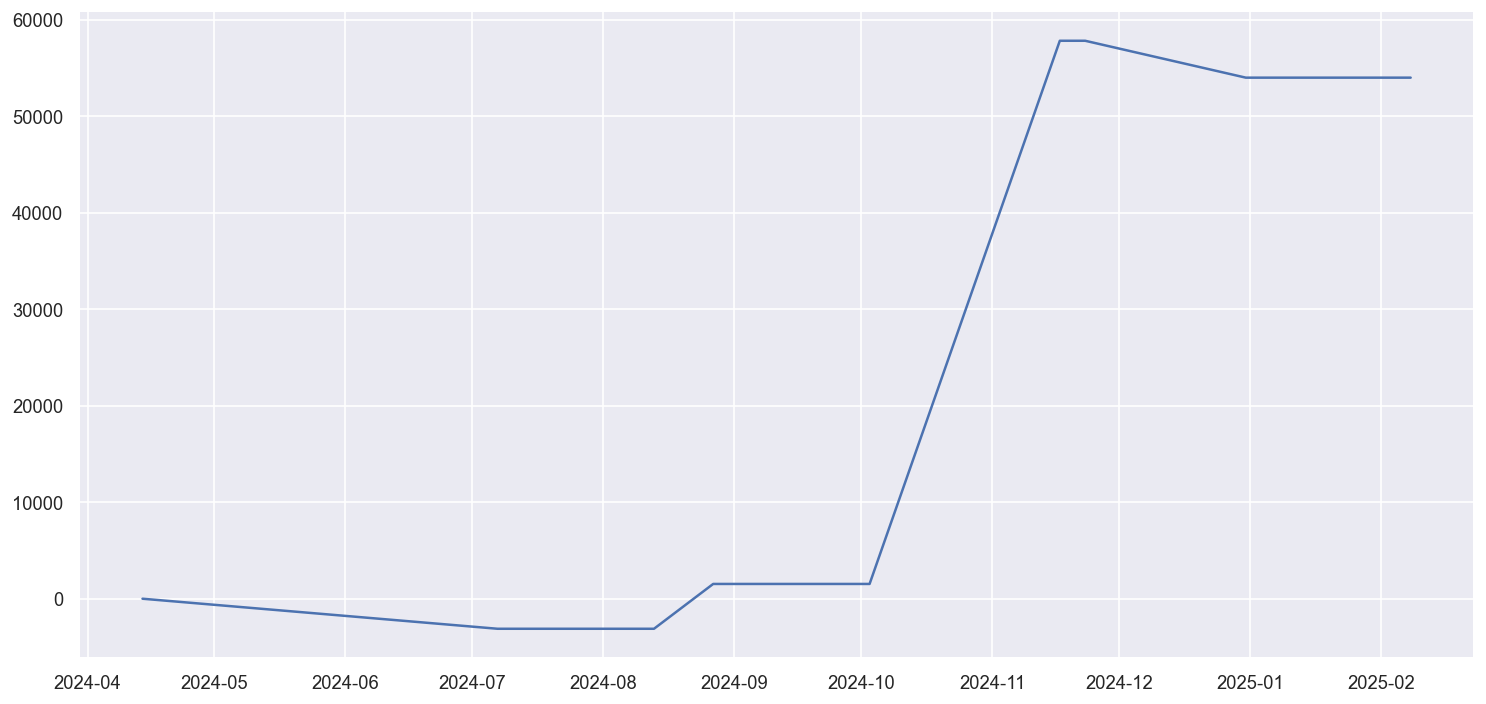

Profit/Loss: 53993.75
Maximum Drawdown: -65500.33
Maximum Holding Period: 84 days 00:00:00


In [34]:
train_results = showResults(txn)

---
## Out-Of-Sample Result

Trade on testing data using the best parameters and show the results

In [35]:
txn = trade(P1, P2, best[0], best[1], test=True)

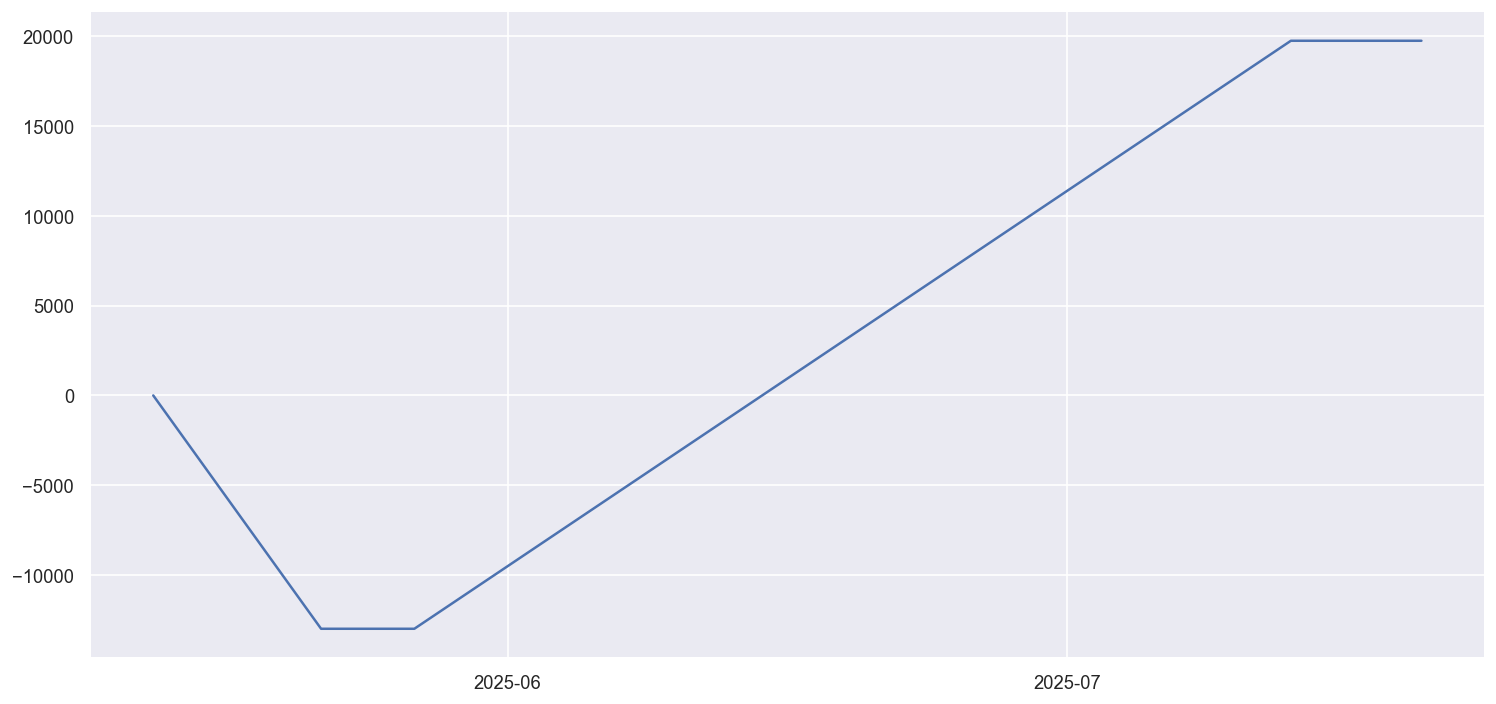

Profit/Loss: 19753.29
Maximum Drawdown: -19332.37
Maximum Holding Period: 47 days 00:00:00


In [36]:
test_results = showResults(txn)

---
## Transaction logs

Showing the transaction logs for validation purpose.

### Transaction log for in-sample (train) dataset

In [37]:
train_results.head()

,action1,coin1,price1,qty1,action2,coin2,price2,qty2,zscore,hedgeratio,net_pnl,drawdown,holdingperiod
datetime,,,,,,,,,,,,,
2024-04-14 00:00:00+00:00,Sell,btc,64404.825489,-1,Buy,xlm,0.105855,608424.876638,1.277905,608424.876638,0.000000,0.000000,0 days
2024-07-07 00:00:00+00:00,Close,btc,58230.484154,-1,Close,xlm,0.090590,608424.876638,0.741948,642793.316364,-3113.428273,-9576.480136,84 days
2024-08-13 00:00:00+00:00,Buy,btc,59350.074333,1,Sell,xlm,0.098846,-600432.006202,-1.007023,600432.006202,-3113.428273,0.000000,0 days
2024-08-27 00:00:00+00:00,Close,btc,62922.586347,1,Close,xlm,0.097060,-600432.006202,-0.699560,648282.940240,1531.001407,0.000000,14 days
2024-10-03 00:00:00+00:00,Sell,btc,60655.559792,-1,Buy,xlm,0.090705,668712.477122,1.008416,668712.477122,1531.001407,0.000000,0 days


### Transaction log for out-of-sample (test) dataset

In [38]:
test_results.head()

,action1,coin1,price1,qty1,action2,coin2,price2,qty2,zscore,hedgeratio,net_pnl,drawdown,holdingperiod
datetime,,,,,,,,,,,,,
2025-05-13 00:00:00+00:00,Sell,btc,102876.830429,-1,Buy,xlm,0.312906,328778.468076,1.000456,328778.468076,0.000000,0.000000,0 days
2025-05-22 00:00:00+00:00,Close,btc,109665.863716,-1,Close,xlm,0.294028,328778.468076,0.749169,372978.080540,-12995.907614,-12995.907614,9 days
2025-05-27 00:00:00+00:00,Sell,btc,109377.715133,-1,Buy,xlm,0.285497,383113.019319,1.068226,383113.019319,-12995.907614,0.000000,0 days
2025-07-13 00:00:00+00:00,Close,btc,117418.957450,-1,Close,xlm,0.391968,383113.019319,0.708843,299562.387570,19753.290822,-19332.372049,47 days
2025-07-20 00:00:00+00:00,Buy,btc,117901.626559,1,Sell,xlm,0.461941,-255230.842437,-1.137191,255230.842437,19753.290822,0.000000,0 days


---
## Key Takeaways

Although the strategy may work for pairs that are deemed statistically cointegrated, one might notice that it may not work all the time. The strategy is too simplistic to be a consistent profit generator.

There are many parameters or factors that can be considered and adjusted and like any automated trading strategy, these settings will need to be dynamically changed over time to align with the latest market conditions.

### Searching for cointegrated pairs using training data
The period and duration of historical data used to identify cointegrated pairs is important. By analysing a longer historical window, pairs found to be cointegrated are more likely to remain cointegrated, at least in the near future.

### Resampling of time series impact to strategy
Resampling of the time series to determined the cointegrated pairs is also important. Pairs that are cointegrated on 1 min time intervals may not be cointegrated on daily intervals. Shorter time intervals translate to more trading opportunities and more data to determine which pairs are cointegrated at these time intervals. However, this does not guarantee greater profits.

### Back-testing of trading strategy
More backtestings and analysis are required to determine if this strategy works well consistently. This analysis is only done based on a single training and testing period.  Instead, one could repeat this analysis on a rolling basis over a longer period to see whether the strategy really works in the long term.

### Maximum drawdown and holding period
Pair trading minimises risk by hedging one asset with another. However, there is still risk involved if the deviation of the pair continues and does not converge fast enough.  This happens when the cointegration assumption is no longer valid, possibly due to specific events in any of the assets. Maximum drawdown calculates the maximum loss one is exposed to at any one particular trade. Note also that the longer it takes for the pair to converge, the longer the holding period, and hence the greater risk the trade is exposed to.

### Cointegrated pairs changes over time
Cointegration is not permanent. Pairs that are cointegrated today might lose that property tomorrow. The advantage of the strategy is the flexibility of dropping pairs when they are no longer cointegrated and add new ones that are.

### Portfolio size, position sizing and quantity
The current strategy, in the long trade, only buys 1 quantity of the 1st asset and hedge by selling with a fraction quantity of the 2nd asset. Similarly, in the short trade, only sells 1 quantity of the 1st asset and hedge by buying a fraction quantity of the 2nd asset. The fraction of quantity to buy or sell in the 2nd asset is determined by a hedge ratio (price of asset 1 / price of asset 2). The hedge ratio calculation may not be optimal here and also the trade execution could be an issue if the quantity to trade is not a round number. A more realistic portfolio-level model would consider total portfolio size, capital allocation and transaction costs.

### Trading multiple pair simultaneously
While the current strategy trades one pair, it could be extended to multiple cointegrated pairs. Each pair would require its own tuning of parameters. A portfolio approach would then manage net exposures and risk at the overall portfolio level.

---
## Future Work

1. Correlation analysis of cryptocurrencies pairs
2. Multiple cointegrated pairs trading
3. Portfolio size adjustments

---
## References
1. [An Introduction to Cointegration for Pairs Trading](https://hudsonthames.org/an-introduction-to-cointegration/)
2. [Quant Strategy: Pairs Trading Algorithm (Mean Reversion)](https://www.youtube.com/watch?v=f73ItMWO4z8&ab_channel=SpencerPao)
3. [Pairs trading based on cointegration](https://databento.com/docs/examples/algo-trading/pairs-trading)